[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/geo-di-lab/emerge-lessons/blob/main/docs/ch4/lesson2.ipynb)

# Environment & Habitats
What are the general environmental conditions at the mosquito observations?

In [ ]:
import pandas as pd
pd.set_option("display.max_columns", None)
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import ee
import geemap
ee.Authenticate()

# Write your project ID here, in quotes
ee.Initialize(project = "emerge-lessons")

In [2]:
mosquito = gpd.read_file('https://github.com/geo-di-lab/emerge-lessons/raw/refs/heads/main/docs/data/globe_mosquito.zip')

For all the Google Earth Engine datasets we looked at in the previous lesson, we'll add the data as extra columns onto the mosquito dataset.

In [3]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.
  Args:
      image (ee.Image): A Sentinel-2 image.
  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

def get_data_for_point(point):
    # Extract the point's date property
    point_date = ee.Date(point.get('MeasuredDate'))
    day_before = point_date.advance(-1, 'day')
    month_before = point_date.advance(-30, 'day')

    #### Land Surface Temperature ####
    lst = (
        ee.ImageCollection('MODIS/061/MOD11A1')
        .filterDate(day_before, point_date)
        .select(['LST_Day_1km', 'QC_Day', 'LST_Night_1km', 'QC_Night', 'Clear_day_cov', 'Clear_night_cov'])
        .median()
        # Sample LST at the point’s location
        .reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=point.geometry(),
            scale=1000
        )
    )
    point = point.set(lst)

    #### Sentinel-2, Median of Previous Month (used to calculate NDVI and NDWI) ####
    sentinel2 = (
        ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterDate(month_before, point_date)
        .map(mask_s2_clouds)
        .median()
        # Sample median band values at the point’s location
        .reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=point.geometry(),
            scale=10
        )
    )
    point = point.set(sentinel2)

    #### Precipitation ####
    rain = (
        ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')
        .filterDate(day_before, point_date)
        .select('precipitation')
        .sum()
        # Sample median band values at the point’s location
        .reduceRegion(
            reducer=ee.Reducer.median(),
            geometry=point.geometry(),
            scale=5566
        )
    )
    point = point.set(rain)

    return point

Because the entire dataset takes up a lot of memory, we will use a subset of the data, from 2024 (which has 2039 observations, compared to the 43009 total observations across 2018-2024).

In [4]:
mosquito_2024 = mosquito[mosquito['MeasuredDate'].str.startswith('2024')]

In [5]:
# Apply the function to all points in 2024
points_fc = geemap.geopandas_to_ee(mosquito_2024)
result_fc = points_fc.map(get_data_for_point)

In [6]:
data = geemap.ee_to_gdf(result_fc)

## Calculate NDVI
data['NDVI'] = (data['B8'] - data['B4']) / (data['B8'] + data['B4'])

## Calculate NDWI
data['NDWI'] = (data['B3'] - data['B8']) / (data['B3'] + data['B8'])

In [7]:
data

,geometry,AOT,B1,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,B9,BreedingGroundEliminated,CountryCode,CountryName,DataSource,Elevation,ExtraData,GlobeTeams,LarvaeCount,LarvaeCountProcessed,LocationAccuracyM,LocationMethod,MSK_CLASSI_CIRRUS,MSK_CLASSI_OPAQUE,MSK_CLASSI_SNOW_ICE,MSK_CLDPRB,MSK_SNWPRB,MeasuredAt,MeasuredDate,MeasurementElevation,MeasurementLatitude,MeasurementLongitude,MosquitoHabitatMapperId,MosquitoPupae,OrganizationId,OrganizationName,Protocol,QA60,QC_Day,QC_Night,SCL,SiteId,SiteName,TCI_B,TCI_G,TCI_R,Userid,WVP,WaterSource,WaterSourcePhotoUrls,WaterSourceType,precipitation,LastIdentifyStage,Clear_day_cov,LST_Day_1km,Clear_night_cov,LST_Night_1km,MosquitoAdults,MosquitoEggs,Comments,LarvaFullBodyPhotoUrls,Genus,Species,AbdomenCloseupPhotoUrls,QA10,QA20,NDVI,NDWI
0,POINT (-44.26597 -2.56197),0.0228,0.10210,0.45830,0.39510,0.1128,0.1506,0.2208,0.27940,0.31590,0.3443,0.31560,0.33190,0.30720,false,BRA,Brazil,GLOBE Observer App,6.3,LarvaeVisibleNo,[COLUNSLZ],0,0.0,13,automatic,0.0,0.0,0.0,0.00000,0.0,2024-12-31T17:16:00,2024-12-31,0,-2.561700,-44.265700,46287,false,17459532,Brazil Citizen Science,mosquito_habitat_mapper,0.0,2.0,2.0,0.00050,371514,23MNT816168,0.01150,0.01540,0.02250,137422629,0.37670,ovitrap,https://data.globe.gov/system/photos/2024/12/3...,container: artificial,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176734,-0.353925
1,POINT (-44.26597 -2.56197),0.0228,0.10210,0.45830,0.39510,0.1128,0.1506,0.2208,0.27940,0.31590,0.3443,0.31560,0.33190,0.30720,false,BRA,Brazil,GLOBE Observer App,6.3,LarvaeVisibleNo,[COLUNSLZ],0,0.0,13,automatic,0.0,0.0,0.0,0.00000,0.0,2024-12-31T17:20:00,2024-12-31,0,-2.561700,-44.265700,46290,false,17459532,Brazil Citizen Science,mosquito_habitat_mapper,0.0,2.0,2.0,0.00050,371514,23MNT816168,0.01150,0.01540,0.02250,137422629,0.37670,ovitrap,https://data.globe.gov/system/photos/2024/12/3...,container: artificial,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176734,-0.353925
2,POINT (-44.30288 -2.51676),0.0168,0.12640,0.30260,0.25450,0.1234,0.1392,0.1886,0.22630,0.22790,0.2369,0.19860,0.23540,0.23600,true,BRA,Brazil,GLOBE Observer App,7.4,LarvaeVisibleNo,[COLUNSLZ],0,0.0,51,automatic,0.0,0.0,0.0,0.00000,0.0,2024-12-31T22:32:00,2024-12-31,0,-2.516300,-44.302300,46482,false,17459532,Brazil Citizen Science,mosquito_habitat_mapper,0.0,3.0,3.0,0.00080,372864,23MNT775218,0.01260,0.01420,0.01920,137420190,0.41330,"cement, metal or plastic tank",NaN,container: artificial,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.025826,-0.175844
3,POINT (-44.05526 -2.86396),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,BRA,Brazil,GLOBE Observer App,20.6,LarvaeVisibleNo,[COLUNSLZ],0,0.0,66,automatic,NaN,NaN,NaN,NaN,NaN,2024-12-31T00:05:00,2024-12-31,0,-2.863900,-44.054900,46203,false,17459532,Brazil Citizen Science,mosquito_habitat_mapper,NaN,2.0,2.0,NaN,373085,23MPS050834,NaN,NaN,NaN,137419937,NaN,can or bottle,NaN,container: artificial,11.092295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-44.05526 -2.86396),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,true,BRA,Brazil,GLOBE Observer App,20.6,LarvaeVisibleNo,[COLUNSLZ],0,0.0,28,automatic,NaN,NaN,NaN,NaN,NaN,2024-12-31T00:23:00,2024-12-31,0,-2.863900,-44.055000,46223,false,17459532,Brazil Citizen Science,mosquito_habitat_mapper,NaN,2.0,2.0,NaN,373085,23MPS050834,NaN,NaN,NaN,137419937,NaN,lake,NaN,still: lake/pond/swamp,11.092295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2037,POINT (2.35801 6.37588),0.0372,0.12305,0.24485,0.21515,0.1320,0.1425,0.1573,0.17280,0.18885,0.2138,0.20650,0.22225,0.20735,true,BEN,Benin,GLOBE Observer App,6.0,LarvaeVisibleYes

If you ran into any errors with the code above (which may happen due to memory issues), you can run the code below to read the data directly from a copy of it we have uploaded to GitHub.

In [ ]:
data = gpd.read_file('https://github.com/geo-di-lab/emerge-lessons/raw/refs/heads/main/docs/data/globe_mosquito_env_2024.zip')

In [10]:
# Remove outliers using the IQR method

larvae_count = data[data['LarvaeCountProcessed'] > 0]

Q1 = larvae_count['LarvaeCountProcessed'].quantile(0.25)
Q3 = larvae_count['LarvaeCountProcessed'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
data_cleaned = data[(data['LarvaeCountProcessed'] >= Q1 - threshold * IQR) & (data['LarvaeCountProcessed'] <= Q3 + threshold * IQR)]

## Plots

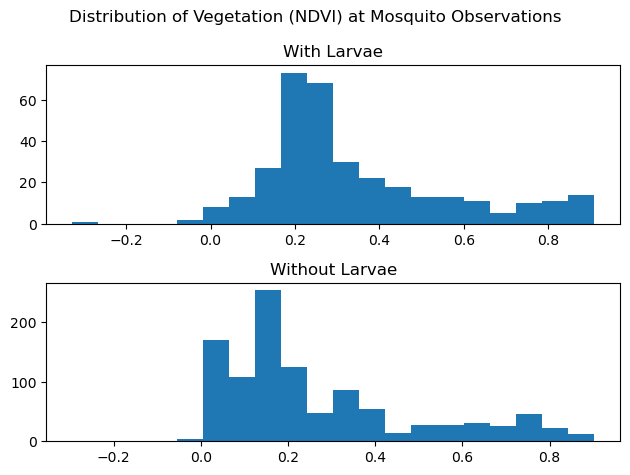

In [11]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(data_cleaned[data_cleaned['LarvaeCountProcessed'] > 0]['NDVI'], bins=20)
ax1.set_title("With Larvae")

ax2.hist(data_cleaned[data_cleaned['LarvaeCountProcessed'] == 0]['NDVI'], bins=20)
ax2.set_title("Without Larvae")

plt.suptitle("Distribution of Vegetation (NDVI) at Mosquito Observations")
plt.tight_layout()

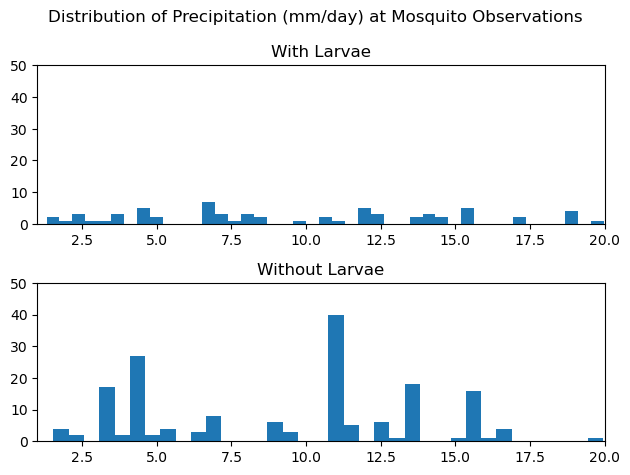

In [12]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.hist(data_cleaned[data_cleaned['LarvaeCountProcessed'] > 0]['precipitation'], bins=200)
ax1.set_title("With Larvae")
ax1.set_xlim([1, 20])
ax1.set_ylim([0, 50])

ax2.hist(data_cleaned[data_cleaned['LarvaeCountProcessed'] == 0]['precipitation'], bins=200)
ax2.set_title("Without Larvae")
ax2.set_xlim([1, 20])
ax2.set_ylim([0, 50])

plt.suptitle("Distribution of Precipitation (mm/day) at Mosquito Observations")
plt.tight_layout()

## Correlation

In [13]:
from scipy.stats import spearmanr

We will perform [Spearman's Rank Order Correlation](https://docs.scipy.org/doc/scipy-1.16.0/reference/generated/scipy.stats.spearmanr.html) using the SciPy Python library. This test gives a correlation coefficient ranging from -1 to 1 measuring the strength of the correlation, where 0 implies no correlation. Positive correlations tell us that as one variable increases, so does the other; and negative correlations tell us that as one decreases, the other decreases as well. Spearman's Correlation is different from Pearson's Correlation in that Pearson's Correlation measures linear relationships, while Spearman's Correlation can measure non-linear relationships.

<Axes: >

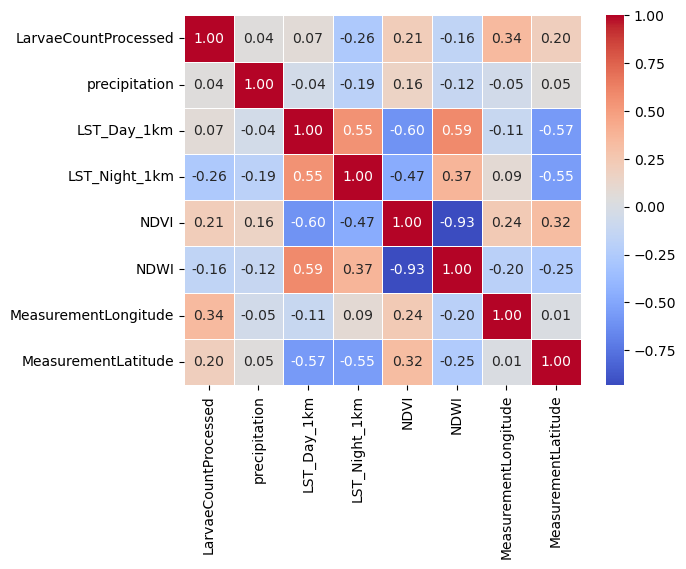

In [14]:
cols = ['LarvaeCountProcessed', 'precipitation', 'LST_Day_1km', 'LST_Night_1km', 'NDVI', 'NDWI', 'MeasurementLongitude', 'MeasurementLatitude']
sns.heatmap(data_cleaned[cols].corr(method='spearman'), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

In [15]:
def interpret_spearmanr(variable, alpha=0.05):
    """Interprets the statistical significance of a Spearman's correlation result"""
    correlation_coefficient, p_value = spearmanr(data_cleaned[variable], data_cleaned['LarvaeCountProcessed'], nan_policy='omit')

    print(f"Spearman's correlation coefficient: {correlation_coefficient:.3f}")
    print(f"P-value: {p_value}")

    if p_value < alpha:
        direction = "positive" if correlation_coefficient > 0 else "negative"
        print(f"The result is statistically significant, with a {direction} correlation.")
    else:
        print("The result is not statistically significant.")

In [16]:
print(f"Number of observations: {len(data_cleaned)}")

print("\n---NDVI and Mosquito Larvae Count---")
interpret_spearmanr('NDVI')

print("\n---Precipitation and Mosquito Larvae Count---")
interpret_spearmanr('precipitation')

print("\n---Night Temperature and Mosquito Larvae Count---")
interpret_spearmanr('LST_Night_1km')

print("\n---Day Temperature and Mosquito Larvae Count---")
interpret_spearmanr('LST_Day_1km')

print("\n---NDVI and Mosquito Larvae Count---")
interpret_spearmanr('NDVI')

Number of observations: 1500

---NDVI and Mosquito Larvae Count---
Spearman's correlation coefficient: 0.213
P-value: 7.937649861422562e-16
The result is statistically significant, with a positive correlation.

---Precipitation and Mosquito Larvae Count---
Spearman's correlation coefficient: 0.044
P-value: 0.09027661706376768
The result is not statistically significant.

---Night Temperature and Mosquito Larvae Count---
Spearman's correlation coefficient: -0.263
P-value: 1.4908278611951026e-10
The result is statistically significant, with a negative correlation.

---Day Temperature and Mosquito Larvae Count---
Spearman's correlation coefficient: 0.067
P-value: 0.17071659768758848
The result is not statistically significant.

---NDVI and Mosquito Larvae Count---
Spearman's correlation coefficient: 0.213
P-value: 7.937649861422562e-16
The result is statistically significant, with a positive correlation.


Next, we will make plots showing the [linear regression model fit](https://seaborn.pydata.org/generated/seaborn.regplot.html) using the seaborn Python library. Think of this as drawing a line that tries to fit the relationship between the environmental variables and the count of the mosquito larvae.

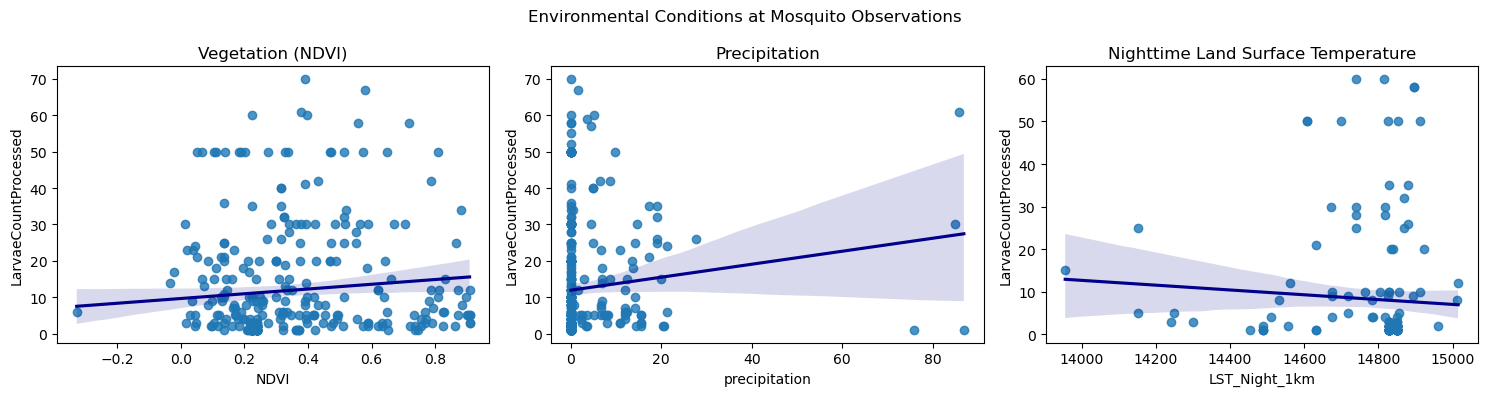

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

sns.regplot(x = "NDVI", y = "LarvaeCountProcessed", data = data_cleaned[data_cleaned['LarvaeCountProcessed'] > 0],
           line_kws = {"color": "darkblue"}, ax = ax1)
ax1.set_title('Vegetation (NDVI)')

sns.regplot(x = "precipitation", y = "LarvaeCountProcessed", data = data_cleaned[data_cleaned['LarvaeCountProcessed'] > 0],
           line_kws = {"color": "darkblue"}, ax = ax2)
ax2.set_title('Precipitation')

sns.regplot(x = "LST_Night_1km", y = "LarvaeCountProcessed", data = data_cleaned[data_cleaned['LarvaeCountProcessed'] > 0],
           line_kws = {"color": "darkblue"}, ax = ax3)
ax3.set_title('Nighttime Land Surface Temperature')

plt.suptitle('Environmental Conditions at Mosquito Observations')
plt.tight_layout()
plt.show()

References
- [SciPy's spearmanr](https://docs.scipy.org/doc/scipy-1.16.0/reference/generated/scipy.stats.spearmanr.html)
- [What Is the Interquartile Range (IQR) Rule?](https://www.thoughtco.com/what-is-the-interquartile-range-rule-3126244)
- [Get an explanation of statistical significance testing with examples in Python](https://developer.ibm.com/articles/statistical-significance-testing-explained-with-examples-in-python/)